In [1]:
import json 
import pandas as pd 
import numpy as np 
import os 
import re 
import seaborn as sns 
import matplotlib.pyplot as plt
from omegaconf import OmegaConf 
from glob import glob 
os.chdir('../')

def load_df(log_dir):
    with open(log_dir, 'r') as f: 
        data = f.readlines()
    df = pd.DataFrame(list(pd.Series(data).map(eval).values))    
    return df 

def load_log_data(class_name, version, result_dir,method):

    df = pd.DataFrame()
    for i,v in enumerate(version):
        log_dir = os.path.join(result_dir,class_name,method,v,'log.txt')
        
        temp_df = load_df(log_dir)
        temp_df['hue'] = v 
        
        df = pd.concat([df,temp_df])
    
    return df 

def plot_log(data,class_name, metrics:list, figsize:tuple = (10,7)):
    
    fig, axes = plt.subplots(len(metrics),1,figsize=figsize)
    
    for ax, metric in zip(axes, metrics):
        sns.lineplot(
            x = 'epoch',
            y = metric,
            data = data,
            hue = data['hue'],
            ax = ax 
        )
      
    fig.suptitle(class_name)
    plt.show()
    
def read_txt(log_dir):
    with open(log_dir, 'r') as f: 
        data = f.readlines()    
    df = pd.DataFrame([eval(d) for d in data]) 
    return df 
pd.options.display.float_format = '{: .3f}'.format 

def temperature_matching(x):
    value = x.split('_')[-1]
    
    if value in ['BASELINE','focalloss']:
        return 0.05 
    elif value in ['T1','T2']:
        return float(value[-1])
    else:
        if len(value) ==1:
            return value 
        else:
            return re.search(r'T_(\d+\.\d+)', x).group(1)
    

# 전체 결과 

In [2]:
                            # /Volume/VAD/Life/results/ReverseDistillation/MVTecAD/hazelnut/pilot-online_False-unified_False-init_ratio_0.5-nb_tasks_5/seed_0/result.txt
log_dirs = pd.Series(glob(f'/Volume/VAD/Life/results/ReverseDistillation/MVTecAD/*/*/*/result.txt'))

df = pd.DataFrame()

for i, log_dir in enumerate(log_dirs):

    cfg = OmegaConf.load(log_dir.replace('result.txt','configs.yaml'))
    data = load_df(log_dir)
    
    result = pd.DataFrame()
    
    if data['task'].max() != 0:
        for t in range(data['task'].max()):
            t_result = pd.DataFrame(data.iloc[t]['test_metrics']).reset_index().melt(['index'])
            t_result['task'] = t 
            
            result = pd.concat([result,t_result])
    else:
        t_result = pd.DataFrame(data[data['epoch']==199]['test_metrics'].values[0]).reset_index().melt(['index'])
        t_result['task'] = t 
                        
        result = pd.concat([result,t_result])
    
    result['class_name'] = cfg.DATASET.class_name
    result['online'] = cfg.CONTINUAL.online
    result['unified'] = cfg.CONTINUAL.unified
    result['init_data_ratio'] = cfg.CONTINUAL.init_data_ratio
    result['nb_tasks'] = cfg.CONTINUAL.nb_tasks
    
    
    df = pd.concat([df,result])

    

In [22]:
fm = pd.DataFrame()
for i, log_dir in enumerate(log_dirs):

    cfg = OmegaConf.load(log_dir.replace('result.txt','configs.yaml'))
    data = load_df(log_dir)
        
    t_result = pd.DataFrame(data[data['task']==-1]['test_metrics'].values[0].items())
    t_result['class_name'] = cfg.DATASET.class_name
    t_result['online'] = cfg.CONTINUAL.online
    t_result['unified'] = cfg.CONTINUAL.unified
    t_result['init_data_ratio'] = cfg.CONTINUAL.init_data_ratio
    t_result['nb_tasks'] = cfg.CONTINUAL.nb_tasks
    
    fm = pd.concat([fm,t_result])

In [30]:
temp = fm[(fm[0]=='fm')&
   fm[1]!=0]
temp[1] = temp[1]*-1

In [38]:
temp.columns=['metric','value','class_name','online','unified','init','nb_tasks']

In [43]:
temp[['class_name','value']]

,class_name,value
0,wood,0.343
0,hazelnut,0.376
0,screw,0.411
0,pill,0.299
0,all,0.140


<AxesSubplot:xlabel='class_name', ylabel='value'>

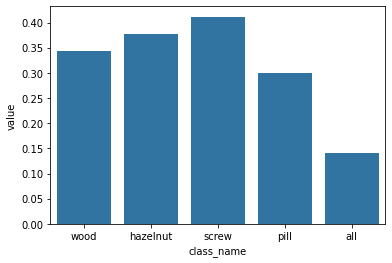

In [42]:
sns.barplot(
    data=temp,
    x='class_name',
    y='value'
    )

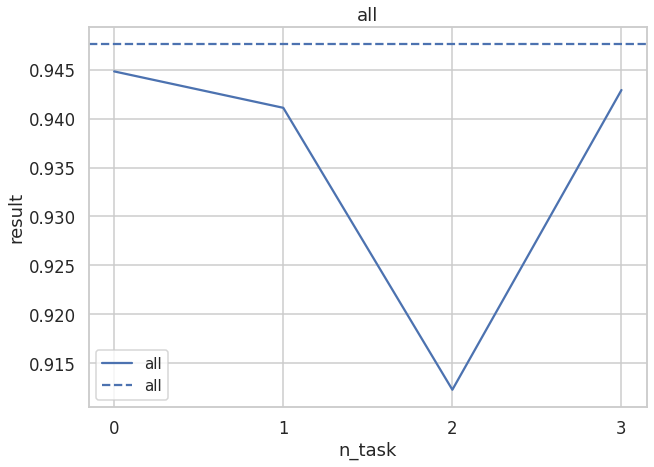

In [293]:
class_name =  ['all']
sns.set(style="whitegrid", context="talk")

for i, cm in enumerate(class_name):
    colors = plt.cm.tab10(np.linspace(0, 1, len(class_name)))

    fig,axes = plt.subplots(1,1,figsize=(10,7))

    temp = df[(df['class_name'] == cm)&
                (df['index'] == 'auroc')&
                (df['variable'] == 'pix_level')&
                (df['nb_tasks'] == 5)
                ]
    sns.lineplot(
        data = temp,
        x = 'task',    
        y = 'value',
        label=temp['class_name'].unique()[0],
        ax= axes
    )


    temp = df[(df['class_name'] == cm)&
                (df['index'] == 'auroc')&
                (df['variable'] == 'pix_level')&
                (df['nb_tasks'] == 1)
                ]

    plt.axhline(y=temp['value'].values[0],  linestyle='--', label=cm)

    plt.ylabel('result')
    plt.xlabel('n_task')
    plt.xticks([0,1,2,3])
    plt.title(cm)
    plt.legend(fontsize=15)
    plt.show()

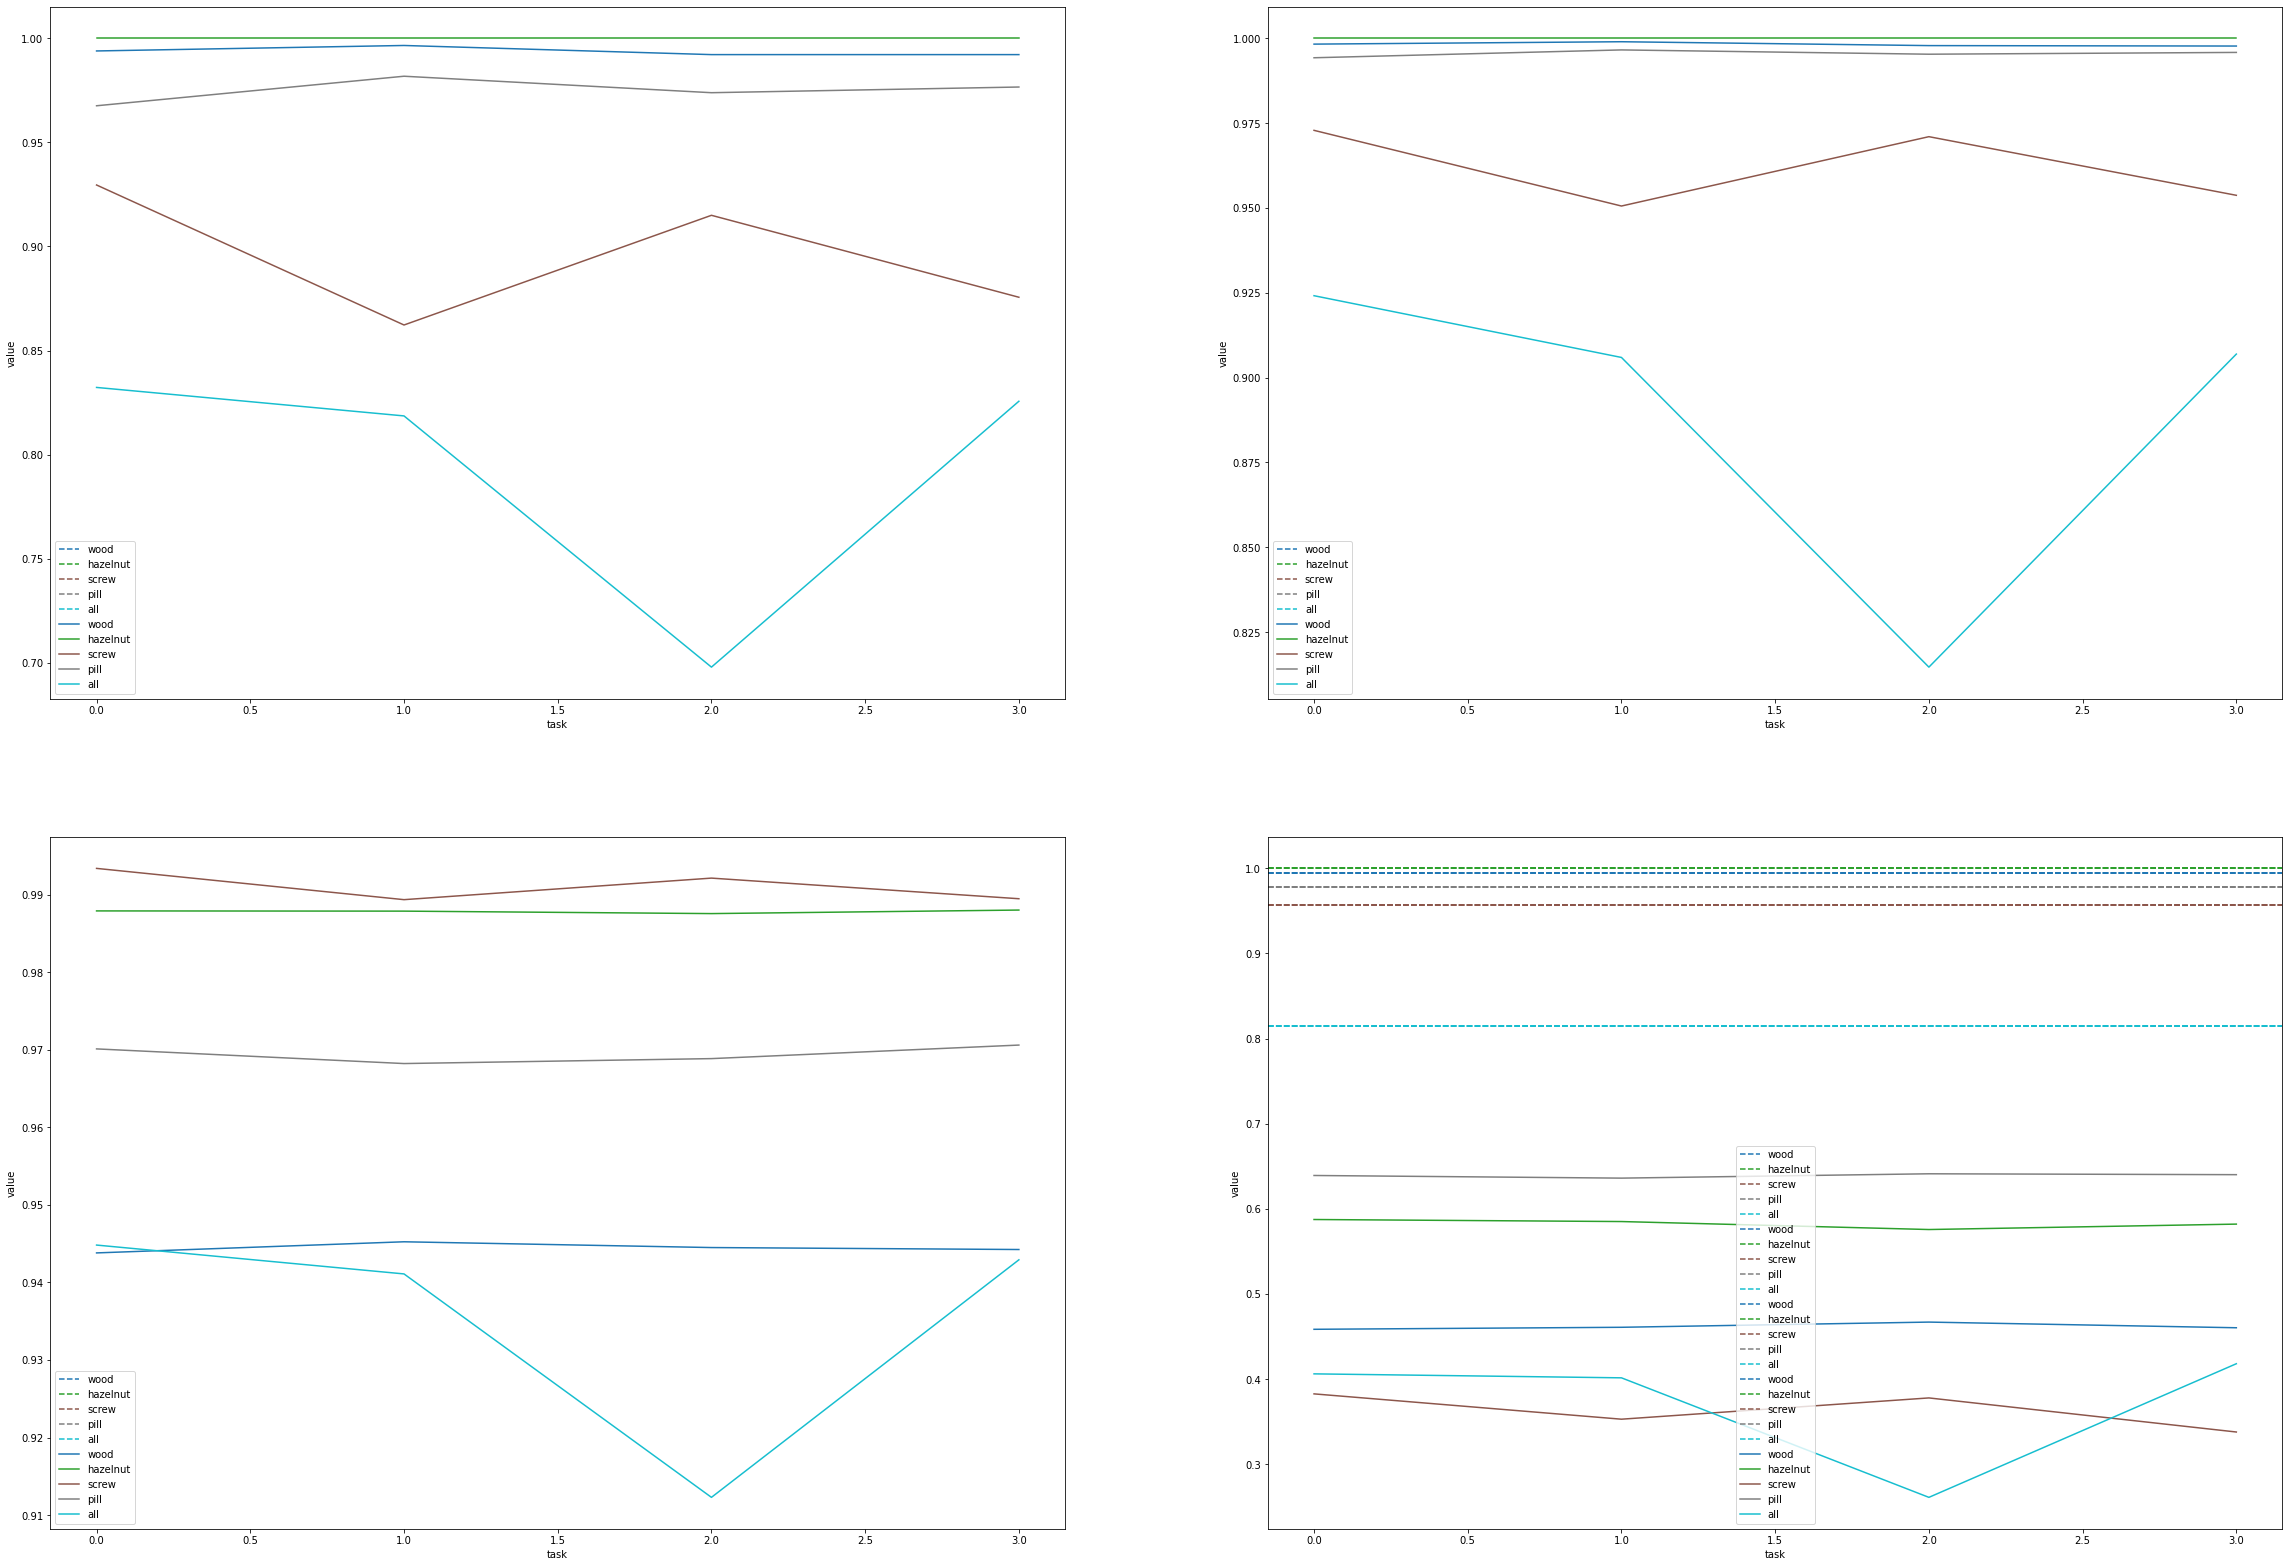

In [250]:
class_name = ['wood', 'hazelnut', 'screw', 'pill','all']
colors = plt.cm.tab10(np.linspace(0, 1, len(class_name)))
color_dict = dict(zip(class_name, colors))

# Figure와 Axes 생성
fig, axes = plt.subplots(2, 2, figsize=(40, 28))

for k, level in enumerate(['img_level','pix_level']):
    for j, metric in enumerate(['auroc','average_precision']):
        # Lineplot
        sns.lineplot(
            data=df[(df['index']    == metric) &
                    (df['variable'] == level) &
                    (df['nb_tasks'] == 5)],
            x='task',
            y='value',
            hue='class_name',
            palette=color_dict,
            ax=axes[k,j]
        )

        # 수평선 그리기
        temp = df[(df['index'] == 'auroc') &
                (df['variable'] == 'img_level') &
                (df['nb_tasks'] == 1)]

        lines = []
        for i in range(len(temp)):
            class_name = temp.iloc[i]['class_name']
            y_value = temp.iloc[i]['value']
            line = plt.axhline(y=y_value, color=color_dict[class_name], linestyle='--', label=class_name)
            lines.append(line)

        # 레전드 추가
        axes[k,j].legend(handles=lines + axes[k,j].get_legend().legendHandles)

        # 그래프 출력

plt.show()